Danayal

In [8]:
# Load various imports 
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa as lb


import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import librosa as lb
from librosa.display import specshow


import os
from os import listdir
from os.path import isfile, join



In [9]:
mypath = "respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [10]:
filenames


['101_1b1_Al_sc_Meditron.wav',
 '101_1b1_Pr_sc_Meditron.wav',
 '102_1b1_Ar_sc_Meditron.wav',
 '103_2b2_Ar_mc_LittC2SE.wav',
 '104_1b1_Al_sc_Litt3200.wav',
 '104_1b1_Ar_sc_Litt3200.wav',
 '104_1b1_Ll_sc_Litt3200.wav',
 '104_1b1_Lr_sc_Litt3200.wav',
 '104_1b1_Pl_sc_Litt3200.wav',
 '104_1b1_Pr_sc_Litt3200.wav',
 '105_1b1_Tc_sc_Meditron.wav',
 '106_2b1_Pl_mc_LittC2SE.wav',
 '106_2b1_Pr_mc_LittC2SE.wav',
 '107_2b3_Al_mc_AKGC417L.wav',
 '107_2b3_Ar_mc_AKGC417L.wav',
 '107_2b3_Ll_mc_AKGC417L.wav',
 '107_2b3_Lr_mc_AKGC417L.wav',
 '107_2b3_Pl_mc_AKGC417L.wav',
 '107_2b3_Pr_mc_AKGC417L.wav',
 '107_2b3_Tc_mc_AKGC417L.wav',
 '107_2b4_Al_mc_AKGC417L.wav',
 '107_2b4_Ar_mc_AKGC417L.wav',
 '107_2b4_Ll_mc_AKGC417L.wav',
 '107_2b4_Lr_mc_AKGC417L.wav',
 '107_2b4_Pl_mc_AKGC417L.wav',
 '107_2b4_Pr_mc_AKGC417L.wav',
 '107_2b4_Tc_mc_AKGC417L.wav',
 '107_2b5_Al_mc_AKGC417L.wav',
 '107_2b5_Ar_mc_AKGC417L.wav',
 '107_2b5_Ll_mc_AKGC417L.wav',
 '107_2b5_Lr_mc_AKGC417L.wav',
 '107_2b5_Pl_mc_AKGC417L.wav',
 '107_2b

In [4]:
files = [f.split('.')[0] for f in filenames]

In [5]:
files

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200',
 '104_1b1_Ar_sc_Litt3200',
 '104_1b1_Ll_sc_Litt3200',
 '104_1b1_Lr_sc_Litt3200',
 '104_1b1_Pl_sc_Litt3200',
 '104_1b1_Pr_sc_Litt3200',
 '105_1b1_Tc_sc_Meditron',
 '106_2b1_Pl_mc_LittC2SE',
 '106_2b1_Pr_mc_LittC2SE',
 '107_2b3_Al_mc_AKGC417L',
 '107_2b3_Ar_mc_AKGC417L',
 '107_2b3_Ll_mc_AKGC417L',
 '107_2b3_Lr_mc_AKGC417L',
 '107_2b3_Pl_mc_AKGC417L',
 '107_2b3_Pr_mc_AKGC417L',
 '107_2b3_Tc_mc_AKGC417L',
 '107_2b4_Al_mc_AKGC417L',
 '107_2b4_Ar_mc_AKGC417L',
 '107_2b4_Ll_mc_AKGC417L',
 '107_2b4_Lr_mc_AKGC417L',
 '107_2b4_Pl_mc_AKGC417L',
 '107_2b4_Pr_mc_AKGC417L',
 '107_2b4_Tc_mc_AKGC417L',
 '107_2b5_Al_mc_AKGC417L',
 '107_2b5_Ar_mc_AKGC417L',
 '107_2b5_Ll_mc_AKGC417L',
 '107_2b5_Lr_mc_AKGC417L',
 '107_2b5_Pl_mc_AKGC417L',
 '107_2b5_Pr_mc_AKGC417L',
 '107_2b5_Tc_mc_AKGC417L',
 '107_3p2_Al_mc_AKGC417L',
 '107_3p2_Ar_mc_AKGC417L',
 '107_3p2_Ll_mc_AKGC417L',
 

In [6]:
def tokenize_file(filename):
    return filename.split('_')

The following is to get the metadata information associated with each file

Two types of audio modes
Stereo or mono

In [7]:
files_ = []
for f in files:
    df = pd.read_csv('./respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/' + f + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    df['filename'] = f
    #get filename features
    f_features = tokenize_file(f)
    df['pId'] = f_features[0]
    df['ac_mode'] = f_features[3]
    
    files_.append(df)
    
files_df = pd.concat(files_)
files_df.reset_index()
files_df.head()

,start,end,crackles,wheezes,filename,pId,ac_mode
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron,101,sc
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron,101,sc
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron,101,sc
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron,101,sc
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron,101,sc


Combine the two metadata dataframes

In [8]:
diagnosis = pd.read_csv('respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['pId', 'diagnosis'])
diagnosis.head()

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


Concatanate the two frames

In [9]:
ds = diagnosis['diagnosis'].unique()

In [10]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pId        126 non-null    int64 
 1   diagnosis  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [11]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   filename  6898 non-null   object 
 5   pId       6898 non-null   object 
 6   ac_mode   6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


PID data type different

In [12]:
files_df['pId'] = files_df['pId'].astype('float64')

In [13]:
files_df = pd.merge(files_df, diagnosis, on='pId')

In [14]:
files_df

,start,end,crackles,wheezes,filename,pId,ac_mode,diagnosis
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
...,...,...,...,...,...,...,...,...
6893,11.721,13.693,1,0,226_1b1_Pl_sc_LittC2SE,226.0,sc,Pneumonia
6894,13.693,15.536,0,0,226_1b1_Pl_sc_LittC2SE,226.0,sc,Pneumonia
6895,15.536,17.493,0,0,226_1b1_Pl_sc_LittC2SE,226.0,sc,Pneumonia
6896,17.493,19.436,1,0,226_1b1_Pl_sc_LittC2SE,226.0,sc,Pneumonia


In [15]:
#code taken from eatmygoose https://www.kaggle.com/eatmygoose/cnn-detection-of-wheezes-and-crackles
def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

To get the length of each slice

In [16]:
files_df['len_per_slice'] = files_df['end'].sub(files_df['start'], axis = 0) 
max_len_per_slice = max(files_df['len_per_slice'])
max_len_per_slice

16.163

16.163 too long for one breath?

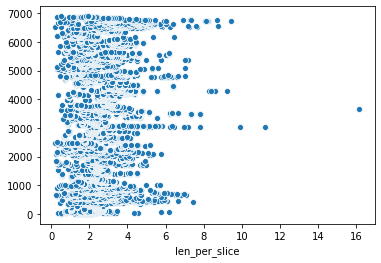

In [17]:
sns.scatterplot(x = files_df['len_per_slice'], y=files_df.index, data = files_df)


Take 6 seconds as the max length for each slice since the majority fall under 6 seconds

In [18]:
force_max_len = 6

Need to find out how much data is present in the 6 seconds of the files. This will vary depending on the acquisiton mode used (stereo vs mono) since
Stereo: (Sampling rate time) 2
Mono: (Sampling rate * time)

In [19]:
def compute_len(samp_rate=22050, time=force_max_len, acquisition_mode=0):
    '''Computes the supposed length of sliced data
        samp_size = sample size from the data
        samp_rate = sampling rate. by default since we're working on 24-bit files, we'll use 96kHz
        time = length of time for the audio file. by default we'll use the max we have which is 5.48
        acquisition_mode = either mono or stereo. 0 for mono, 1 for stereo
    '''
    comp_len = 0
    if acquisition_mode == 1: #ac mode is single channel which means it's 'mono'
        comp_len = samp_rate * time
    else: #stereo
        comp_len = (samp_rate * time) * 2

    return comp_len

In [20]:
# import os
# os.makedirs('output1')

In [21]:
# for d in ds:
#     path = os.path.join('output1', d)
#     os.makedirs(path)

In [22]:
import soundfile as sf

In [23]:
# i = 0 #iterator for file naming

# for idx, row in files_df.iterrows():
#     filename = row['filename']
#     start = row['start']
#     end = row['end']
#     diag = row['diagnosis']
    
#     #check len and force to 6 sec if more than that
#     if force_max_len < end - start:
#         end = start + force_max_len
    
#     aud_loc = './respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/' + f + '.wav'
    
#     if idx != 0:
#         if files_df.iloc[idx-1]['filename'] == filename:
#             i=i+1
#         else:
#             i=0
#     n_filename = filename + '_' + str(i) + '.wav'
#     path = 'output1/' + diag + '/' + n_filename
    
#     data, samplingrate = lb.load(aud_loc)
#     sliced_data = slice_data(start=start, end=end, raw_data=data, sample_rate=samplingrate)
    
#     #pad audio if < forced_max_len
#     a_len = compute_len(samp_rate=samplingrate, acquisition_mode=row['ac_mode']=='sc')
#     padded_data = lb.util.pad_center(sliced_data, a_len)

#     sf.write(file=path, data=padded_data, samplerate=samplingrate)

In [24]:
!pip install split_folders

In [25]:
import split_folders

In [26]:
# os.makedirs('output1/train')
# os.makedirs('output1/val')

In [27]:
# audio_loc = 'output1'

# split_folders.ratio(audio_loc, output='output1', seed=1337, ratio=(0.8, 0.2))

In [28]:
categories = diagnosis['diagnosis'].unique()
categories

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [29]:
def is_wav(filename):
    '''
        Checks if files are .wav files
        Utility tool in converting wav to png files
    '''
    return filename.split('.')[-1] == 'wav'

change to mel not linear

In [30]:
#create images using librosa spectogram
def convert_to_spec_image(file_loc, filename, category, is_train=False, verbose=False):
    ''' 
        Converts audio file to spec image
        Input file includes path
        Saves the file to a png image in the save_directory
    '''
    train_ = 'train/'
    val_ = 'val/'
    
    loc = file_loc + train_ + category + '/' + filename
    if is_train == False:
        loc = file_loc + val_ + category + '/' + filename

#     if verbose == True:
#         print('reading and converting ' + filename + '...')
        
    y, sr = lb.load(loc)

    #Plot signal in
    plt.figure(figsize=(10,3))
    src_ft = lb.stft(y)
    src_db = lb.amplitude_to_db(abs(src_ft))
    specshow(src_db, sr=sr, x_axis='time', y_axis='hz')  
    plt.ylim(0, 5000)
    
    save_directory = 'output1/'
    filename_img = filename.split('.wav')[0]
    
    save_loc = save_directory + train_ + category + '/' + filename_img + '.png'
    if is_train == False:
        save_loc = save_directory + test_ + category + '/' + filename_img + '.png'
        
    plt.savefig(save_loc)
    
#     if verbose == True:
#         print(filename + ' converted!')
        
    plt.close()


In [31]:
files_loc = 'output1/'

In [32]:
# #do this a thousand a time... laptop keeps crashing otherwise

# split = ['train', 'val']

# for s in split:
#     for cat in categories:
#         files = [f for f in listdir(files_loc + s + '/' + cat + '/') if isfile(join(files_loc + s + '/' + cat + '/', f)) and is_wav(f)]
#         for f in files[1000]:
#             convert_to_spec_image(file_loc = files_loc, category=cat, filename=f, is_train=(s == 'train'), verbose=True)
#             if f == files[1000]:
#                 print ("reached")
#                 break

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics



from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

In [13]:
train_loc = 'train_test_split/train/'
test_loc = 'train_test_split/val/'

In [14]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224))

Found 5515 images belonging to 8 classes.
Found 1383 images belonging to 8 classes.


In [72]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Dropout
# from keras.layers import MaxPooling2D
# from keras.layers import Flatten
# from keras.layers import Conv2D
# from keras.callbacks import ModelCheckpoint


In [101]:
model = Sequential()
# model.add()
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(224,224,3)))
#model.add(Dropout(0.5))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
# model.add(Dense(100, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 788544)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 6308360   
Total params: 6,310,152
Trainable params: 6,310,152
Non-trainable params: 0
_________________________________________________________________


In [102]:
# ### vgg16_2 = VGG16(weights='imagenet')
# vgg16_2.summary()

In [103]:
# vgg16 = VGG16(weights='imagenet')
# vgg16.summary()

# x  = vgg16.get_layer('fc2').output
# prediction = Dense(8, activation='softmax', name='predictions')(x)

# model = Model(inputs=vgg16.input, outputs=prediction)

In [104]:
# for layer in model.layers:
#     layer.trainable = False

# for layer in model.layers[-9:]:
#     layer.trainable = True
#     print("Layer '%s' is trainable" % layer.name)  

In [105]:
opt = Adam(lr=0.000001)
model.compile(optimizer=opt, loss=categorical_crossentropy, 
              metrics=['accuracy', 'mae'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 788544)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 6308360   
Total params: 6,310,152
Trainable params: 6,310,152
Non-trainable params: 0
_________________________________________________________________


In [106]:
checkpoint = ModelCheckpoint("vgg16_base_res.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
not use weights

In [107]:
counter = Counter(traindata.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1149.0,
 1: 55.373493975903614,
 2: 35.90625,
 3: 1.0,
 4: 17.883268482490273,
 5: 183.84,
 6: 20.157894736842106,
 7: 23.690721649484537}

In [108]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [109]:
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata, 
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size, 
                 epochs=110,callbacks=[checkpoint,early])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 172 steps, validate for 43 steps
Epoch 1/110
171/172 [============================>.] - ETA: 1s - loss: 168.3893 - accuracy: 0.1631 - mae: 0.2089
Epoch 00001: val_accuracy improved from -inf to 0.47965, saving model to vgg16_base_res.h5
172/172 [==============================] - 210s 1s/step - loss: 167.6396 - accuracy: 0.1652 - mae: 0.2084 - val_loss: 89.5812 - val_accuracy: 0.4797 - val_mae: 0.1324
Epoch 2/110
171/172 [============================>.] - ETA: 1s - loss: 103.8765 - accuracy: 0.3040 - mae: 0.1742
Epoch 00002: val_accuracy did not improve from 0.47965
172/172 [==============================] - 219s 1s/step - loss: 103.9952 - accuracy: 0.3022 - mae: 0.1747 - val_loss: 146.0682 - val_accuracy: 0.0167 - val_mae: 0.2455
Epoch 3/110
171/172 [============================>.] - ETA: 1s - loss: 123.8380 - accuracy: 0.1989 - mae: 0.2002
Epoch 00003: val_accuracy did not improve from 0.47965
172/172 [=======================

Epoch 25/110
171/172 [============================>.] - ETA: 1s - loss: 36.3520 - accuracy: 0.5183 - mae: 0.1214
Epoch 00025: val_accuracy did not improve from 0.78779
172/172 [==============================] - 254s 1s/step - loss: 36.3081 - accuracy: 0.5160 - mae: 0.1220 - val_loss: 96.4182 - val_accuracy: 0.2384 - val_mae: 0.1874
Epoch 26/110
171/172 [============================>.] - ETA: 1s - loss: 36.4310 - accuracy: 0.5190 - mae: 0.1215
Epoch 00026: val_accuracy did not improve from 0.78779
172/172 [==============================] - 254s 1s/step - loss: 36.5388 - accuracy: 0.5169 - mae: 0.1220 - val_loss: 138.8614 - val_accuracy: 0.3597 - val_mae: 0.1564
Epoch 27/110
171/172 [============================>.] - ETA: 1s - loss: 27.9621 - accuracy: 0.5302 - mae: 0.1187
Epoch 00027: val_accuracy did not improve from 0.78779
172/172 [==============================] - 258s 1s/step - loss: 28.0359 - accuracy: 0.5309 - mae: 0.1186 - val_loss: 108.7747 - val_accuracy: 0.5821 - val_mae: 0.1

In [110]:
model.save("1sttry.h5")


In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)


In [ ]:
transfer learning to use weights from known models